# MsPASS Short Course:  SAGE-GAGE 2022
## Session 1:   Overview
The purpose of this notebook is to provide a overview of the main features of MsPASS.  It should 
also reinforce key concepts we addressed in the preceding lecture. 
The notebook will lead you through the following steps:

1.  We will assemble a small, working data set.  It will be built from miniseed data we previously 
    downloaded with the obspy FDSN waveform web service.   Each of you will download your own copy 
    of source and receiver metadata and see how we load these into the database and produce 
    cross-references to the waveform data.  
2.  We will run a set of common, simple processing steps.  These are a mix of database operations to 
    associate the right source and receiver metadata with each waveform and some lightweight waveform 
    manipulation to window data around a theoretical P time and bundle the data into three-component
    data objects.  
3.  We illustrate how easy it is to translate a serial workflow to a parallel workflow.  That will 
    provide the background for the following section that is focused completely on parallel processing.

This notebook can be run after the workshop on a local machine with the package called docker installed. 
For the workshop we will be running this notebook on stampede2 at TACC where we will use singularity 
instead of docker.

## Preprocessing:  assembling a working data set for this session
### Source selection
We are going to be working with the reflection seismology equivalent of a shot gather.  
For this session we will be working with a single magnitude 7.0 aftershock of the 2012 
Tohoku earthquake recorded by the USArray.

The first step is to pull the detailed source information and save it our database.

In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client=Client("IRIS")
t0=UTCDateTime('2011-04-07T14:32:44.100000Z')
starttime=t0-3600.0
endtime=t0+3600.0
lat0=38.3
lon0=142.5
minlat=lat0-3.0
maxlat=lat0+3.0
minlon=lon0-3.0
maxlon=lon0+3.0
minmag=6.5

cat=client.get_events(starttime=starttime,endtime=endtime,
        minlatitude=minlat,minlongitude=minlon,
        maxlatitude=maxlat,maxlongitude=maxlon,
        minmagnitude=minmag)
print(cat)

1 Event(s) in Catalog:
2011-04-07T14:32:44.100000Z | +38.251, +141.730 | 7.1 MW


Note the above is a pure obspy python script.   They define a *Catalog* object they use to store event information.  A *Catalog* is more or less an image of the quakeml format data delivered by FDSN web service calls that the IRIS DMC just responded to when you ran that box.  The next box makes the first use of a MsPASS.  This short script saves the *Catalog* we just created into the MsPASS database system (based on MongoDB):

In [2]:
#from mspasspy.db.client import DBClient
#from mspasspy.db.database import Database
#dbclient = DBClient()
#db = Database(dbclient,"sagegage_2022")
# new form does not work
from mspasspy.client import Client
mp_client = Client()
db = mp_client.get_database('sagegage_2022')

In [3]:
n=db.save_catalog(cat)
print('number of event entries saved in source collection=',n)

number of event entries saved in source collection= 1


#### Select stations and download station metadata
We now need to do parallel procedure to retrieve any relevant station information.  For this exercise we are going to use only data from the USArray "TA" stations, which have the SEED net code "TA".   As with sources we use obspy's web service client, but in this case we retrieve station data:

In [4]:
inv=client.get_stations(network='TA',starttime=starttime,endtime=endtime,
                        format='xml',channel='BH?',level='response')
net=inv.networks
x=net[0]
sta=x.stations
print("Number of stations retrieved=",len(sta))
#print(inv)

Number of stations retrieved= 433


Similar to the source data, obspy's web service client creates an image of the returned stationxml data that they call an *Inventory*.   We next use a parallel, simple database method to save this python object to our working database:

In [5]:
ret=db.save_inventory(inv)

Database.save_inventory processing summary:
Number of site records processed= 434
number of site records saved= 434
number of channel records processed= 1308
number of channel records saved= 1302


In this case, this function produced only a summary of what it wrote.  There is a verbose mode we turned off that would have told us that the reason the last two lines have a different number is that web services returned 6 duplicates.   As those of you who have worked with a lot of IRIS data probably know there are a lot of station metadata inconsistencies in what you get from web services.   Anyone who has had to deal with experimental data totally understand why, but it is a truth and a never ending job people at DMC and other data centers face.   The point for this session is that save_inventory always checks for duplicates and will silently skip them unless the verbose option is turned on.  If running verbose the duplicates will still be skipped, but you will get an error message.  Although we skipped it here, in general we recommend running save_inventory in verbose mode to make sure you are aware of any warts in the station metadata. 

### Load waveform data 
Normally obtaining waveform data that define your "dataset" can be a time consuming process.   
The waveform data you will be using today was originally downloaded with obspy using a python 
script similar to this:

    #####################################################################
    import os   # need this for directory handling
    from obspy import UTCDateTime
    db=Database(dbclient,'shortcourse')
    dbsource=db.source
    doc=dbsource.find_one()   
    origin_time=doc['time']
    # We need the ObjectId of the source to provide a cross reference to link our 
    # waveform data to the right source.  Better to do this now than later as association 
    # can be a big challenge
    id=doc['_id']    
    print('Starting to download data for event with origin time=',UTCDateTime(origin_time))
    start_offset=763.0-4*60.0   # 763 is an approximate P wave travel time to TA center
    end_offset=1400.0+10*60.0
    stime=origin_time+start_offset
    etime=origin_time+end_offset
    t0=time.time()
    strm=client.get_waveforms(
            starttime=UTCDateTime(stime),
            endtime=UTCDateTime(etime),
            network='TA',
            station='*',
            channel='BH?',
            location='*'
        )
    # The output of get_waveforms is an obspy Stream object. Stream objects are iterable 
    # so we work through the group saving each waveform to a separate file
    # That is a terrible approach, but one we will use for pedagotic reasons in session 2
    i=0   # used as a counter for creating unique mseed file names in this script
    filebase='shortcourse'
    dir='./wf'
    if not os.path.exists(dir):
        os.makedirs(dir)
    for d in strm:
        # We use obspy's writer here to save these data as miniseed.  We will be using that version 
        # of the data set in a later session.  There writer by default uses the SAC model of one 
        # file per Trace so we have to create a large number of files.
        filename = "{base}_{count}.mseed".format(base=filebase,count=i)
        d.write(dir+"/"+filename,format='MSEED')
        i += 1
        path=dir+"/"+filename
        db.index_mseed_file(path)
    #####################################################################

If you pulled this tutorial from github the above script should allow you to recreate the set of 
miniseed files we will use in the workshop.  Some file name hacking will likely be required if you are in 
that situation. 

Students in the workshop need only run the following code box:


In [6]:
import os
wfdir = "/tmp/wf"   # change this directory as needed
with os.scandir(wfdir) as entries:
    count=0
    for entry in entries:
        if entry.is_file():
            filename= wfdir +'/'+entry.name
            print("Processing file=",filename)
            db.index_mseed_file(entry.name, dir=wfdir)
            count += 1
print('Number of files processed=',count)

Processing file= /tmp/wf/shortcourse_26.mseed
Processing file= /tmp/wf/shortcourse_528.mseed
Processing file= /tmp/wf/shortcourse_272.mseed
Processing file= /tmp/wf/shortcourse_488.mseed
Processing file= /tmp/wf/shortcourse_716.mseed
Processing file= /tmp/wf/shortcourse_993.mseed
Processing file= /tmp/wf/shortcourse_1164.mseed
Processing file= /tmp/wf/shortcourse_733.mseed
Processing file= /tmp/wf/shortcourse_910.mseed
Processing file= /tmp/wf/shortcourse_340.mseed
Processing file= /tmp/wf/shortcourse_657.mseed
Processing file= /tmp/wf/shortcourse_511.mseed
Processing file= /tmp/wf/shortcourse_1066.mseed
Processing file= /tmp/wf/shortcourse_520.mseed
Processing file= /tmp/wf/shortcourse_169.mseed
Processing file= /tmp/wf/shortcourse_688.mseed
Processing file= /tmp/wf/shortcourse_543.mseed
Processing file= /tmp/wf/shortcourse_31.mseed
Processing file= /tmp/wf/shortcourse_837.mseed
Processing file= /tmp/wf/shortcourse_573.mseed
Processing file= /tmp/wf/shortcourse_33.mseed
Processing fil

Processing file= /tmp/wf/shortcourse_75.mseed
Processing file= /tmp/wf/shortcourse_629.mseed
Processing file= /tmp/wf/shortcourse_352.mseed
Processing file= /tmp/wf/shortcourse_416.mseed
Processing file= /tmp/wf/shortcourse_610.mseed
Processing file= /tmp/wf/shortcourse_1061.mseed
Processing file= /tmp/wf/shortcourse_713.mseed
Processing file= /tmp/wf/shortcourse_239.mseed
Processing file= /tmp/wf/shortcourse_726.mseed
Processing file= /tmp/wf/shortcourse_70.mseed
Processing file= /tmp/wf/shortcourse_472.mseed
Processing file= /tmp/wf/shortcourse_598.mseed
Processing file= /tmp/wf/shortcourse_462.mseed
Processing file= /tmp/wf/shortcourse_503.mseed
Processing file= /tmp/wf/shortcourse_848.mseed
Processing file= /tmp/wf/shortcourse_957.mseed
Processing file= /tmp/wf/shortcourse_530.mseed
Processing file= /tmp/wf/shortcourse_1028.mseed
Processing file= /tmp/wf/shortcourse_1030.mseed
Processing file= /tmp/wf/shortcourse_741.mseed
Processing file= /tmp/wf/shortcourse_365.mseed
Processing f

Processing file= /tmp/wf/shortcourse_140.mseed
Processing file= /tmp/wf/shortcourse_873.mseed
Processing file= /tmp/wf/shortcourse_648.mseed
Processing file= /tmp/wf/shortcourse_769.mseed
Processing file= /tmp/wf/shortcourse_1124.mseed
Processing file= /tmp/wf/shortcourse_175.mseed
Processing file= /tmp/wf/shortcourse_639.mseed
Processing file= /tmp/wf/shortcourse_787.mseed
Processing file= /tmp/wf/shortcourse_405.mseed
Processing file= /tmp/wf/shortcourse_802.mseed
Processing file= /tmp/wf/shortcourse_510.mseed
Processing file= /tmp/wf/shortcourse_122.mseed
Processing file= /tmp/wf/shortcourse_35.mseed
Processing file= /tmp/wf/shortcourse_898.mseed
Processing file= /tmp/wf/shortcourse_236.mseed
Processing file= /tmp/wf/shortcourse_181.mseed
Processing file= /tmp/wf/shortcourse_263.mseed
Processing file= /tmp/wf/shortcourse_875.mseed
Processing file= /tmp/wf/shortcourse_498.mseed
Processing file= /tmp/wf/shortcourse_1151.mseed
Processing file= /tmp/wf/shortcourse_431.mseed
Processing f

Processing file= /tmp/wf/shortcourse_851.mseed
Processing file= /tmp/wf/shortcourse_174.mseed
Processing file= /tmp/wf/shortcourse_1177.mseed
Processing file= /tmp/wf/shortcourse_455.mseed
Processing file= /tmp/wf/shortcourse_1114.mseed
Processing file= /tmp/wf/shortcourse_1283.mseed
Processing file= /tmp/wf/shortcourse_1043.mseed
Processing file= /tmp/wf/shortcourse_754.mseed
Processing file= /tmp/wf/shortcourse_983.mseed
Processing file= /tmp/wf/shortcourse_435.mseed
Processing file= /tmp/wf/shortcourse_556.mseed
Processing file= /tmp/wf/shortcourse_691.mseed
Processing file= /tmp/wf/shortcourse_334.mseed
Processing file= /tmp/wf/shortcourse_1167.mseed
Processing file= /tmp/wf/shortcourse_600.mseed
Processing file= /tmp/wf/shortcourse_928.mseed
Processing file= /tmp/wf/shortcourse_1046.mseed
Processing file= /tmp/wf/shortcourse_522.mseed
Processing file= /tmp/wf/shortcourse_985.mseed
Processing file= /tmp/wf/shortcourse_10.mseed
Processing file= /tmp/wf/shortcourse_117.mseed
Processi

Note the loop builds only an index to the waveform files. For Antelope user's that loop is functionally similar to running miniseed2db. In this case instead of creating a css3.0 "wfdisc" table we are creating a "wf_miniseed" *collection*.   (A *collection* in MongoDB plays the same role as a table/relation in a relational database but as we will see later is handled differently.)  


### Data Preprocessing
#### Quick Look
Any form of data processing requires graphical displays at times to evaluate the results.  In MsPASS we currently have a basic plotter to handle native data types.  We will not cover plotting details in this course, but students are referred to the MsPASS tutorial on graphics for additional information and guidance on alternative approaches.

The following short script selects BHZ channels from the database and plots only the first 10 it finds.  

Number of BHZ channels= 429
Plotting only first 10


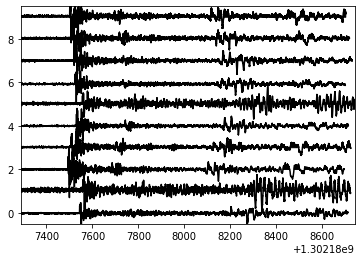

In [7]:
from mspasspy.ccore.seismic import TimeSeriesEnsemble
from mspasspy.graphics import SeismicPlotter
ensemble=TimeSeriesEnsemble()
query={ 'chan' : 'BHZ'}
n=db.wf_miniseed.count_documents(query)
print('Number of BHZ channels=',n)
print('Plotting only first 10')
curs=db.wf_miniseed.find(query).limit(10)
ensemble = db.read_ensemble_data(curs,collection="wf_miniseed")
plotter=SeismicPlotter(normalize=True)
plotter.change_style('wtva')
plotter.plot(ensemble)

One thing to note about the plot above is that the time scale is unix epoch time, but the matplotlib routines we use for the plotting convert that axis to a readable scale in seconds relative to the start time.  

### Metadata Association
#### Receiver Metadata
In a later section of this course we will go into more details about the database we use in MsPASS.  For the present the thing to recognize is that in the first few boxes of this notebook we downloaded source and receiver metadata and saved them to the database.   We also saved the waveform data in one of two methods, but in both cases the end result was a set of data stored as miniseed files.  A property of miniseed is that a unique channel is defined by five key attributes:  network code, station code, channel code, (when set) a location code, and a time stamp.   The miniseed data have absolutely no reference to what source we are examining. Anyone who has dealt with miniseed data knows it is can be a thorny problem to associate the right source and receiver metadata with each channel of data.  

We have a standard database method for associating channel metadata to data objects derived from miniseed files illustrated by the following script:

In [8]:
cursor=db.wf_miniseed.find({})
for doc in cursor:
    net=doc['net']
    sta=doc['sta']
    chan=doc['chan']
    wftime=doc['starttime']
    chandoc=db.get_seed_channel(net,sta,chan,time=wftime)
    sitedoc=db.get_seed_site(net,sta,time=wftime)
    chanid=chandoc['_id']
    siteid=sitedoc['_id']
    wfid=doc['_id']
    match={'_id' : wfid}
    updatedef={'$set' : {'channel_id' : chanid, 'site_id' : siteid}}
    db.wf_miniseed.update_one(match,updatedef)        
               

There are likely some pieces of the above that at this point you might view as an "incantation", but the key thing to notice are the calls to the database methods _get_seed_channel_ and _get_seed_site_.  Both return a special MongoDB thing called an "ObjectID" that we use extensively in MsPASS for cross-referencing.   The reason is the ObjectIDs involved always have an index defined and yield fast searches at the cost of being defined by a not so human friendly id value.  The script above finds unique records where station metadata are stored and sets an id field in each waveform.   The is done here through the low-level _update_one_ method for the database handle. The above works because of the special property of seed enforced by the FDSN that a channel of data can be uniquely identified by the five keys:  net, sta, chan, loc, and time.  We ignore loc above because we know that the TA did not use any loc codes.  

#### Source Metadata
The data we are working with here is a generalization of the seismic reflection processing idea of a "shot gather", meaning the data all come from a single earthquake with a common origin time.  Miniseed data have no concept of source metadata.  The general problem of linking source information to a given waveform has near infinite complexity, but for this first-order view of MsPASS the algorithm we need is pretty trivial; the complexity is only in the arcane syntax of MongoDB we need to make implement it: 

In [9]:
doc=db.source.find_one()
srcid=doc['_id']
cursor=db.wf_miniseed.find({})
for doc in cursor:
    wfid=doc['_id']
    db.wf_miniseed.update_one({'_id' : wfid},{'$set' : {'source_id' : srcid}})

To show that did something useful here we read back the first 6 waveforms and show how source and receiver data are stored in the generalized headers for these data:

In [10]:
cursor=db.wf_miniseed.find({}).limit(6)
print('net sta chan channel_lat channel_lon channel_elev source_lat source_lon source_depth source_time')
normalize_list=['source','channel']
for doc in cursor:
    d=db.read_data(doc,normalize=normalize_list,collection='wf_miniseed')
    print(d['net'],d['sta'],d['chan'],d['channel_lat'],d['channel_lon'],d['channel_elev'],
         d['source_lat'],d['source_lon'],d['source_depth'],UTCDateTime(d['source_time']))

net sta chan channel_lat channel_lon channel_elev source_lat source_lon source_depth source_time
TA 136A BHZ 32.474602 -96.529701 0.113 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA F32A BHE 45.870499 -97.126404 0.371 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA 737A BHZ 28.763901 -96.440201 0.011 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA E33A BHZ 46.503502 -96.005402 0.428 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA J34A BHZ 43.284401 -95.957901 0.432 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z
TA Q37A BHE 38.876301 -94.452202 0.297 38.2513 141.7296 53.2 2011-04-07T14:32:44.100000Z


## Simple Serial Workflows
In section we illustrate some simple MsPASS workflows that use simple serlia processing driven by for loops.  In the main section following we will show a parallel version of the most elaborate serial workflow.
### Cut around P time
Our first example just reads the first 5 waveforms in the database, applies a simple filter, computes a theoretical P wave arrival time from the source and receiver metadata, windows the data relative to that P wave arrival time, and then plots the data.  

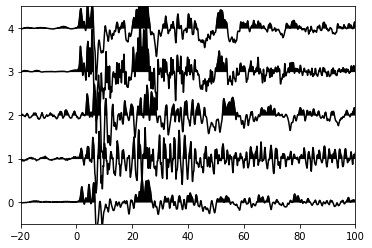

In [11]:
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.signals import filter
from mspasspy.ccore.algorithms.basic import TimeWindow
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees
# First we load all the data we want to work with into a single ensemble object
# limited to 5 here to keep the plot legible
ensemble=TimeSeriesEnsemble()
#cursor=db.wf_miniseed.find({'chan' : 'BHZ'}).limit(5)
cursor=db.wf_miniseed.find({}).limit(5)
ensemble=db.read_ensemble_data(cursor,collection='wf_miniseed',normalize=normalize_list)

# This a time window in time relative to P arrival around 
# which we cut each waveform
cutwin=TimeWindow(-20.0,100.0)
i=0
for d in ensemble.member:
    filter(d,'bandpass',freqmax=2.0,freqmin=0.005)
    stalat=d['channel_lat']
    stalon=d['channel_lon']
    srclat=d['source_lat']
    srclon=d['source_lon']
    depth=d['source_depth']
    otime=d['source_time']
    georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)
    # obspy's function we just called returns distance in m in element 0 of a tuple
    # their travel time calculator it is degrees so we need this conversion
    dist=kilometers2degrees(georesult[0]/1000.0)
    arrivals=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=dist,phase_list=['P'])
    # Arrivals are returned in time order 0 is always the first arrival
    # This computes arrival time as an epoch time and shifts the data to put 0 at that time
    d.ator(otime+arrivals[0].time)
    #d=WindowData(d,cutwin)
    ensemble.member[i]=WindowData(d,cutwin.start,cutwin.end)
    i+=1
plotter.plot(ensemble)

### Bundle into Seismogram objects
A novel feature of MsPASS is treating three-component data as a distinct data type.   The following box does that process to a subset of the entire data set.  We only do a subset of the data for two reasons.  (1) The default memory allocation in docker may cause problems on some machines if we used the algorithm below the full event gather.  (2)  An intentiona error allows us to illustrate another key feature of MsPASS.

In [12]:
from mspasspy.algorithms.bundle import bundle_seed_data
# This query causes the list of TimeSeries to be sorted by sta name
# We need that only because we are also limiting the number of data read
cursor=db.wf_miniseed.find({}).limit(10).sort('sta',1)
ensemble=db.read_ensemble_data(cursor,collection='wf_miniseed',normalize=normalize_list)
print('Ensemble size=',len(ensemble.member))
print('running bundle_seed_ensemble')
d3c=bundle_seed_data(ensemble)
print('Size of bundled ensemble=',len(d3c.member))

db.save_ensemble_data(d3c,data_tag='rawsample')

Ensemble size= 10
running bundle_seed_ensemble
Size of bundled ensemble= 4


Now if we are assembling bundles of 3 from a set of 10 TimeSeries what is the best that could happen?  We'd get 3 groups of 3 and one orphan.   Why did we get 4 bundles then?  This clarifies why as well as allowing me to use the best python joke ever!

In [13]:
from mspasspy.util.Undertaker import Undertaker
print('station status')
for d in d3c.member:
    print(d['sta'],d.live)
stedronsky=Undertaker(db)
[good_guys,zombies]=stedronsky.bring_out_your_dead(d3c)
print('\nThe undertaker found ',len(good_guys.member),
      ' data objects were marked live and ',len(zombies.member),' were marked dead\n')
print('Error log showing why datum was killed')
for i in range(len(zombies.member)):
    log=zombies.member[i].elog.get_error_log()
    for m in log:
        print(m.algorithm,m.message)

station status
109C False
035Z True
035A True
034A True

The undertaker found  3  data objects were marked live and  1  were marked dead

Error log showing why datum was killed
bundle_seed_data Insufficient data to generate Seismogram object.
Number of channels received  for bundling=1
Number marked live=1
Number live must be at least 3



This illustrates two important concepts used in MsPASS that you need to recognize:
1.   We borrow the ancient practice of marking data dead from from seismic reflection data processing. As we will see later that approach is critical for the parallel processing system to work cleanly.
2.   Errors are always something that have to be handled because only a trivial data set is clean enough to not generate one or more problems that have to be handled.  Again because of the parallel framework the cleanest way we found to handle this is to carry the errors along with the data with which that error is associated.   The *elog* symbol contains that error log in each data object.

### Database clean method
Converting data downloaded miniseed into these three component data objects creates a bunch of metadata inconsistencies.  In this case it is pervasive, but a whole range of things can create database inconsistencies a system like MsPASS needs to handled.   

To see the specific problem here let's just take a look at the metadata associated with the first 
seismogram.

In [14]:
from bson import json_util
n3c=db.wf_Seismogram.count_documents({})
print('Database current has ',n3c,' Seismogram objects')
doc=db.wf_Seismogram.find_one()
print(json_util.dumps(doc,indent=2))

Database current has  3  Seismogram objects
{
  "_id": {
    "$oid": "62a11fee982bfdae8393ba41"
  },
  "channel_elev": 0.019,
  "channel_lon": -98.068298,
  "dfile": "shortcourse_8.mseed",
  "channel_id": {
    "$oid": "62a11f78982bfdae8393b024"
  },
  "cardinal": false,
  "channel_endtime": 1321815600.0,
  "orthogonal": false,
  "storage_mode": "gridfs",
  "nbytes": 65536,
  "tmatrix": [
    0.0,
    0.0,
    1.0,
    0.00872653549840032,
    0.9999619230641711,
    2.6484540326036093e-14,
    0.9999619230641713,
    -0.008726535498373787,
    2.6484540326036093e-14
  ],
  "time_standard": "Relative",
  "format": "mseed",
  "utc_convertible": false,
  "dir": "/tmp/wf",
  "chan": "BHZ",
  "channel_edepth": 0.0,
  "delta": 0.025,
  "last_packet_time": 1302188741.6499999,
  "starttime": 1302187287.1,
  "site_id": {
    "$oid": "62a11f78982bfdae8393b022"
  },
  "channel_starttime": 1262995200.0,
  "foff": 0,
  "source_id": {
    "$oid": "62a11f6d982bfdae8393b01b"
  },
  "sampling_rate": 4

There are a number of attributes that are inconsistent with the data that are relics of single channel concepts, which we call TimeSeries data.   Examples are "chan" and several items with the structure "channel_X" where X is some suffix whose meaning you might guess (e.g. channel_lat is station latitude).  

We can fix these easily with a special method in the Database object we call clean_collection

In [15]:
db.clean_collection('wf_Seismogram',delete_undefined=True)
doc=db.wf_Seismogram.find_one()
print(json_util.dumps(doc,indent=2))

{
  "_id": {
    "$oid": "62a11fee982bfdae8393ba41"
  },
  "dfile": "shortcourse_8.mseed",
  "cardinal": false,
  "orthogonal": false,
  "storage_mode": "gridfs",
  "tmatrix": [
    0.0,
    0.0,
    1.0,
    0.00872653549840032,
    0.9999619230641711,
    2.6484540326036093e-14,
    0.9999619230641713,
    -0.008726535498373787,
    2.6484540326036093e-14
  ],
  "time_standard": "Relative",
  "format": "mseed",
  "utc_convertible": false,
  "dir": "/tmp/wf",
  "delta": 0.025,
  "starttime": 1302187287.1,
  "site_id": {
    "$oid": "62a11f78982bfdae8393b022"
  },
  "foff": 0,
  "source_id": {
    "$oid": "62a11f6d982bfdae8393b01b"
  },
  "sampling_rate": 40.0,
  "npts": 55566,
  "gridfs_id": {
    "$oid": "62a11fee982bfdae8393ba3a"
  },
  "history_object_id": "a33d01e8-162d-4273-b283-ca000166d203",
  "data_tag": "rawsample"
}


Most of the relics are gone now, although there are a few that require a different approach to repair we will not inflict on you for now.   

The final point about data saved as *Seismogram* objectgs is they contain all the data and internal methods needed to handle any coordinate transformation. The next box illustrates this further:

transformation matrix defined in database
[0.0, 0.0, 1.0, 0.00872653549840032, 0.9999619230641711, 2.6484540326036093e-14, 0.9999619230641713, -0.008726535498373787, 2.6484540326036093e-14]


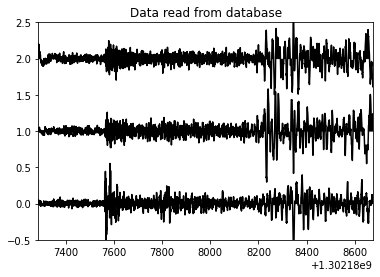

In [16]:
doc=db.wf_Seismogram.find_one()
print('transformation matrix defined in database')
print(doc['tmatrix'])
d=db.read_data(doc,collection='wf_Seismogram')
# this just makes the data look a little better
filter(d,'bandpass',freqmax=2.0,freqmin=0.01)
plotter.title='Data read from database'
plotter.plot(d)

What the printed output and the graphic show is that the data bundle assembled are not in cardinal directions (EW, NS, Z).  There are two reasons for that in this case:  (1) the TA measured orientations to high accuracy and the metadata told the system the measured orientations that were used to compute the transformation matrix, and (2) the bundle algorithm we ran didn't bother to try to assemble the components in any standard order.  We can regularize the data with a method in Seismogram used like this:

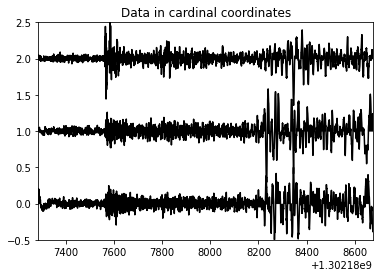

In [17]:
d.rotate_to_standard()
plotter.title='Data in cardinal coordinates'
plotter.plot(d)

Finally, we want to do some more things with Seismogram data in the next session.  What we did above was intentionally small to keep the output small.  Here we do the same process, but aim for 100 Seismogram objects in the read and add a line to save the result to the database.

In [18]:
cursor=db.wf_miniseed.find({}).limit(300).sort('sta',1)
ensemble=db.read_ensemble_data(cursor,collection='wf_miniseed',normalize=normalize_list)
print('Ensemble size=',len(ensemble.member))
d3c=bundle_seed_data(ensemble)
print('Size of bundled ensemble=',len(d3c.member))
db.save_ensemble_data(d3c,data_tag='rawdataset')

Ensemble size= 300
Size of bundled ensemble= 100
